In [250]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# Global constants for earth
G = 6.6742*10**-11 # gravitational constant, Nm^2/kg^2
M = 5.9722*10**24 # mass of earth, kg
R = 6371*10**3 # radius of earth, m

# Global constants for rocket
m = 1
A = 1
C_d = 1

In [251]:
def force_gravity(m, x, y):
    '''Calculate the force of gravity on a mass m due to earth.
    
    Parameters:
    
    m : mass of object [kg]
    x : x distance away from the center of earth [m]
    y : y distance away from the center of earth [m]
    
    Returns:
    
    F_g_x, F_g_y: Force on mass m due to gravity in x and y directions respectively [N]'''
    
    # force magnitude
    F_g = G*M*m/(x**2 + y**2)
    
    theta = np.arctan2(y,x)
    F_g_x = F_g * np.cos(theta)
    F_g_y = F_g * np.sin(theta)
    
    return F_g_x, F_g_y

In [252]:
def air_density(x, y):
    '''Calculate (a close approximation of) the air density at a given distance away from the center of earth.
    
    Parameters:
    
    x : x distance away from the center of earth [m]
    y : y distance away from the center of earth [m]
    
    Returns:
    
    Density at point (x,y) [kg/m^3]'''
    
    
    rho_0 = 1.225 # sea level density, kg/m^3
    L = 0.0065 # temperature lapse rate, K/m
    T = 288.15 # temperature, K. Temperature is obviously NOT constant and this is a simplification
    M = 0.0289644 # molar mass of dry air, kg/mol
    R_gas = 8.31447 # ideal gas constant, J/(mol K)
    F_g_x, F_g_y = force_gravity(m, x, y) # acceleration due to gravity at (x, y) in x and y directions [m/s^2]
    g = np.sqrt(F_g_x**2 + F_g_y**2)/m
    r = np.sqrt(x**2 + y**2)
    
    rho = rho_0 * np.exp(-g*M*(r-R)/(R_gas*T))

    return rho

In [253]:
def force_drag(x, y, vx, vy, variable_density=True):
    '''Return the drag force and object experiences during flight.
    
    Parameters:
    
    x : x distance away from the center of earth [m]
    y : y distance away from the center of earth [m]
    vx : x velocity of object
    vy : y velocity of object
    variable_density: toggle on/off variable density. Defaults to True. When false, density is constant.
    
    Returns:
    
    F_drag_x, F_drag_y: Force due to drag in x and y directions respectively [N]'''
    
    rho = air_density(x, y)
    
    # for testing purposes
    if not variable_density:
        rho = 1.16
    
    b = 1/(2*m) * rho * A * C_d
    
    # Pulled from past homework assignment
    F_drag_x = b*np.sqrt(vx**2 + vy**2)*vx
    F_drag_y = b*np.sqrt(vx**2 + vy**2)*vy

    return F_drag_x, F_drag_y

In [300]:
# No thrust force yet
def acceleration(x, y, vx, vy):
    F_g_x, F_g_y = force_gravity(m, x, y)
    F_drag_x, F_drag_y = force_drag(x, y, vx, vy)
    
    F_net_x = (-F_g_x - F_drag_x)/m
    F_net_y = (-F_g_y - F_drag_y)/m

    return F_net_x, F_net_y

In [306]:
def F4(init, t):
    x, y = init[0], init[1]
    vx, vy = init[2], init[3]
    ax, ay = acceleration(x, y, vx, vy)
    
    return np.array([vx, vy, ax, ay])

In [307]:
def test_F4(init, t_max, N):
    T = np.linspace(0, t_max, N)
    
    data = odeint(F4, init, T)
    x, y, vx, vy = data[:,0], data[:, 1], data[:,2], data[:,3]
    
    print(x[-1], y[-1], np.sqrt(x[-1]**2 + y[-1]**2))
    print(vx[-1], vy[-1])

    plt.figure(figsize=(20,3))
    
    plt.subplot(1,3,1)
    plt.plot(x, y)
    plt.title('Trajectory')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.axis('equal')
    plt.plot(0, 0, 'ro')
    
    earth = plt.Circle((0,0), R, color='green')
    plt.subplot(1,3,1).add_patch(earth)

    plt.subplot(1,3,2)
    plt.plot(T, x)
    plt.title('x vs t')
    plt.xlabel('t (s)')
    plt.ylabel('x (m)')

    plt.subplot(1,3,3)
    plt.plot(T, y)
    plt.title('y vs t')
    plt.xlabel('t (s)')
    plt.ylabel('x (m)')
    plt.show()
    
    plt.figure(figsize=(20,3))
    
    plt.subplot(1,2,1)
    plt.plot(T, vx)
    plt.title('vx vs t')
    plt.xlabel('t (s)')
    plt.ylabel('vx (m/s)')
    
    plt.subplot(1,2,2)
    plt.plot(T, vy)
    plt.title('vy vs t')
    plt.xlabel('t (s)')
    plt.ylabel('vy (m/s)')
    
    plt.show()
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.gca(projection='3d')
    
    z = np.zeros_like(x)
    #z = np.array(range(N))
    ax.plot(x, y, z, 'm')
    ax.plot([x[0]], [y[0]], [z[0]], 'bo', label='inital position')
    ax.plot([x[-1]], [y[-1]], [z[-1]], 'ro', label='final position')
    plt.legend(loc='best')
    
    u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:30j]
    X = R*np.cos(u)*np.sin(v)
    Y = R*np.sin(u)*np.sin(v)
    Z = R*np.cos(v)
    ax.plot_wireframe(X, Y, Z, color="green")
    
    
    max_limit = max(np.max(x), np.max(y), np.max(z))
    ax.set_xlim(-max_limit, max_limit)
    ax.set_ylim(-max_limit, max_limit)
    ax.set_zlim(-max_limit, max_limit)
    
    plt.title('3D Trajectory Plot')

    plt.show()
    


In [308]:
def print_init(init):
    print('INITIAL CONDITIONS')
    print('x =', init[0])
    print('y =', init[1])
    print('vx =', init[2])
    print('vy =', init[3])

In [311]:
def plot_test_F4():
    G = 6.6742*10**-11 # gravitational constant, Nm^2/kg^2
    M = 5.9722*10**24 # mass of earth, kg
    R = 6371*10**3 # radius of earth, m
    
    y = R + 250e3
    v0 = np.sqrt(G*M)/(0 + (y)**2)**(1/4)
    
    init1 = np.array([0, y, v0, 0])
    init2 = np.array([0, R*3, 3310, 1000])
    init3 = np.array([0, R*2, 7310, 1000])
    init4 = np.array([0, R + 300e3, v0, 0])
    init5 = np.array([0, R+150e3, v0*0.8, v0*0.8]) 
    
    print_init(init1)
    test_F4(init1, 30*10000, 10000)

    print_init(init2)
    test_F4(init2, 100000, 100000)
    
    print_init(init3)
    test_F4(init3, 1000000, 100000)

    print_init(init4)
    test_F4(init4, 10000, 100000)
    
    print_init(init5)
    test_F4(init5, 10000, 100000)

INITIAL CONDITIONS
x = 0.0
y = 6621000.0
vx = 7758.98631654
vy = 0.0
2732999.90326 -5687308.09803 6309893.96687
-0.0433843142898 0.090281730963


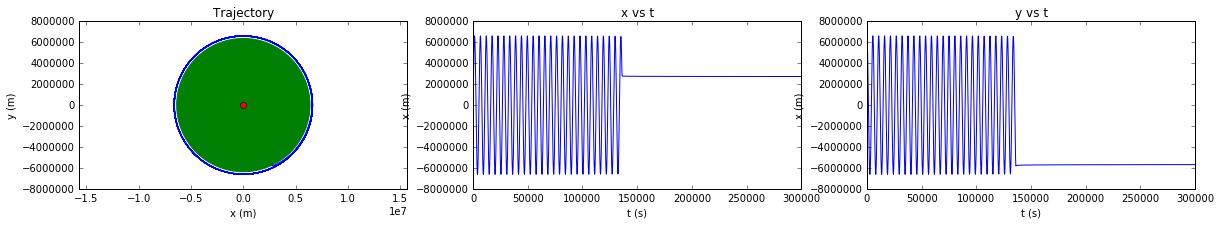

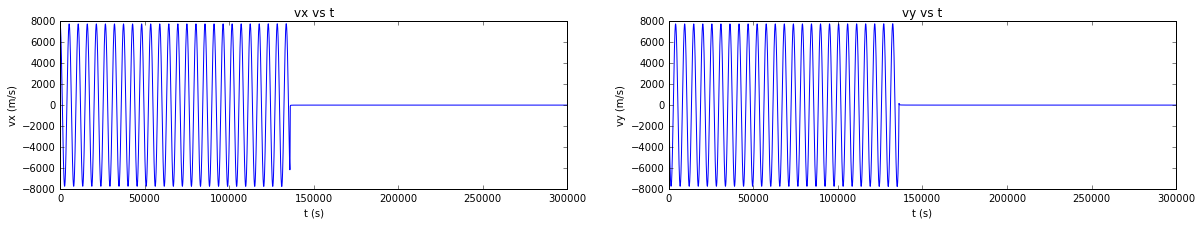

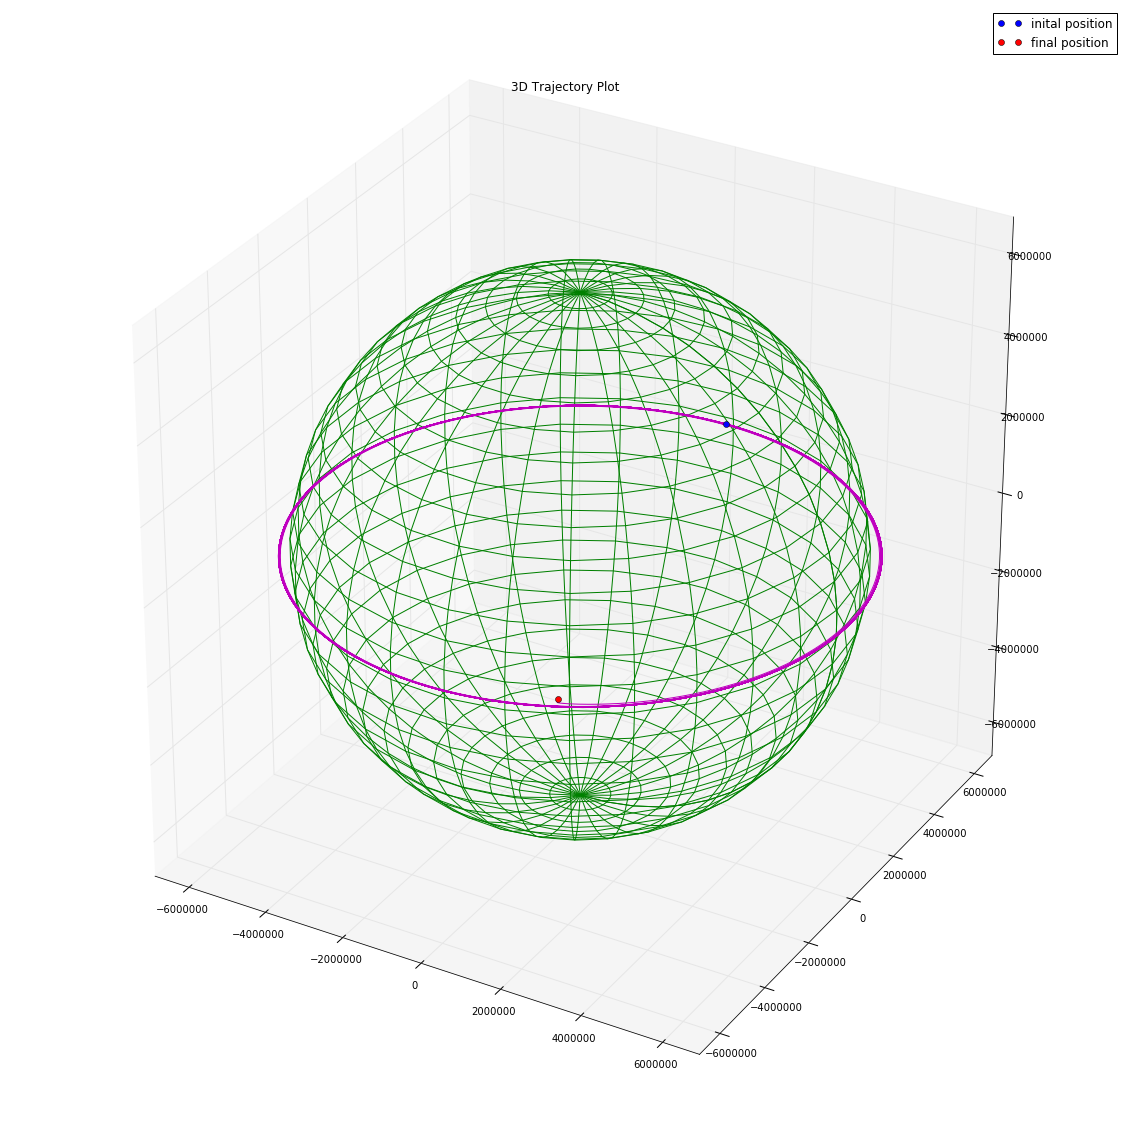

INITIAL CONDITIONS
x = 0
y = 19113000
vx = 3310
vy = 1000
12427933.2346 949205.893597 12464129.1839
-2510.71390052 -5282.22768719


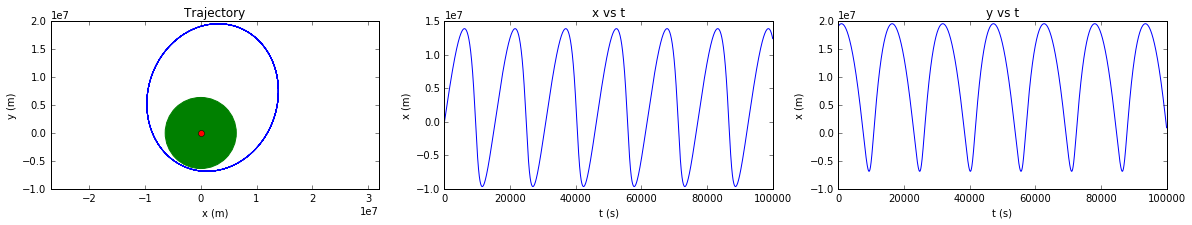

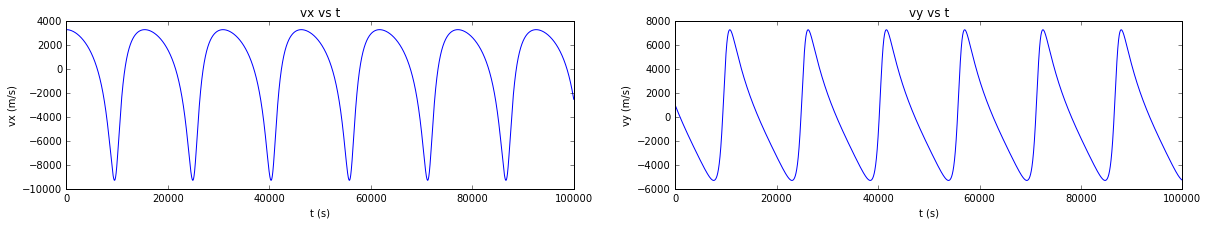

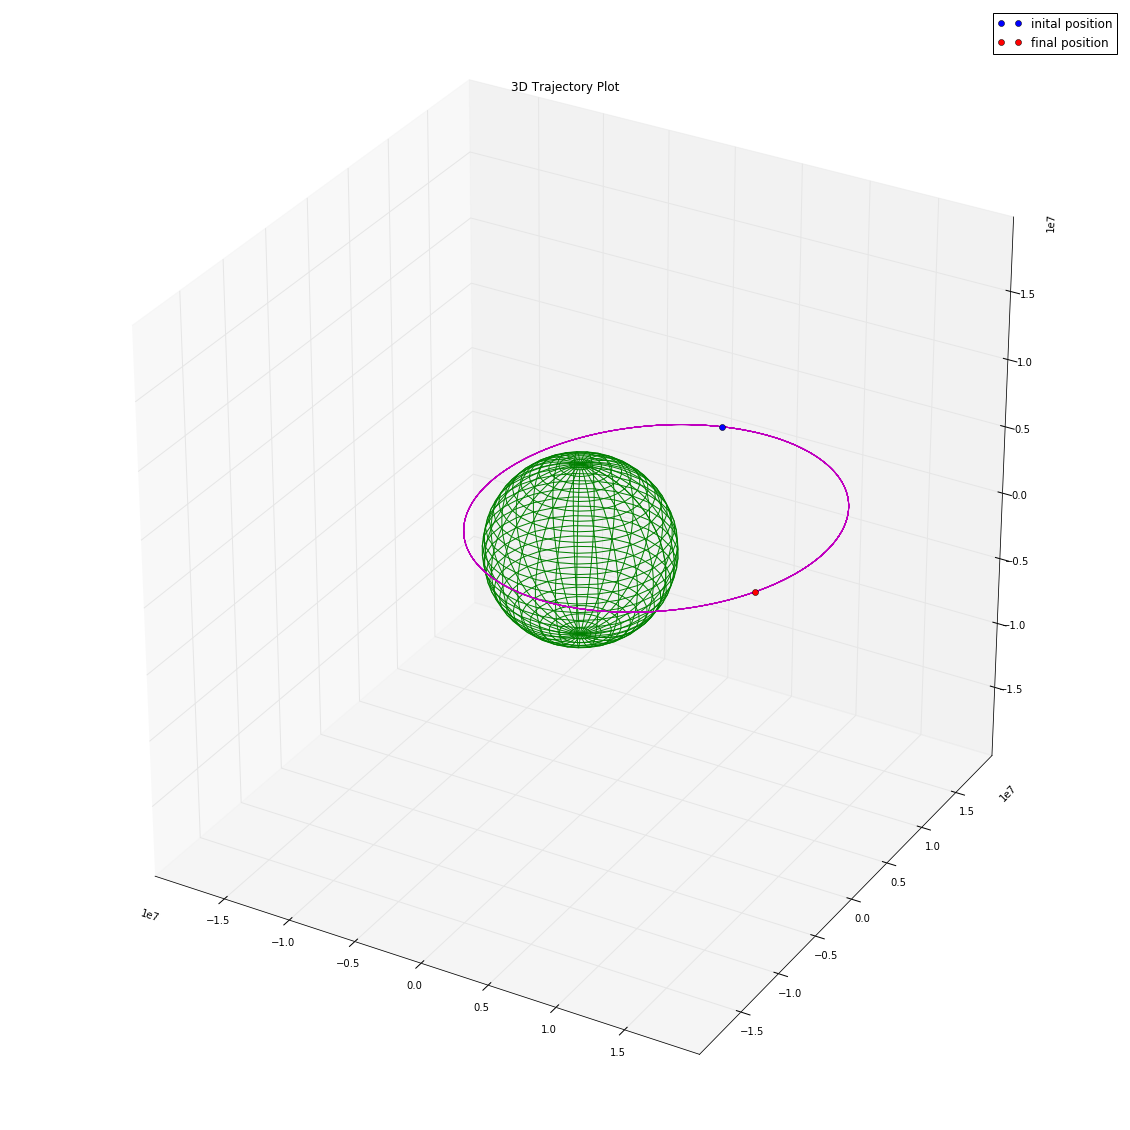

INITIAL CONDITIONS
x = 0
y = 12742000
vx = 7310
vy = 1000
45491051.1595 -54539457.261 71021040.0791
-255.619954531 -1741.05739398


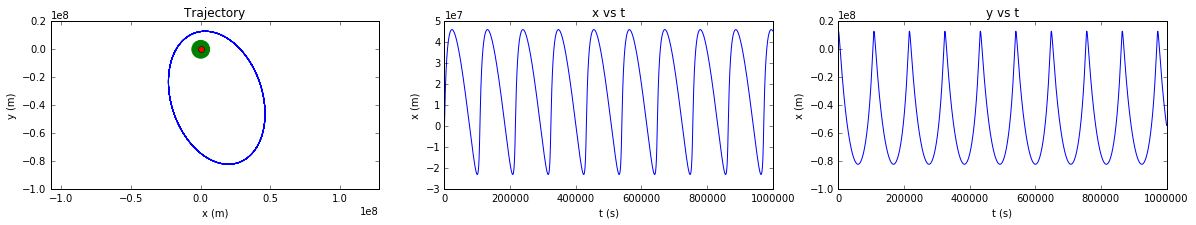

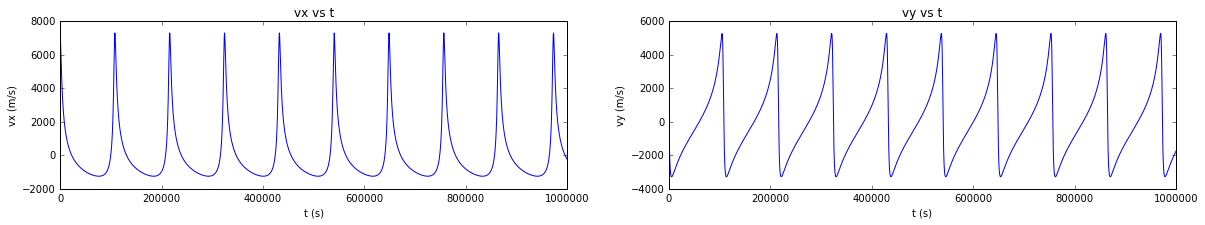

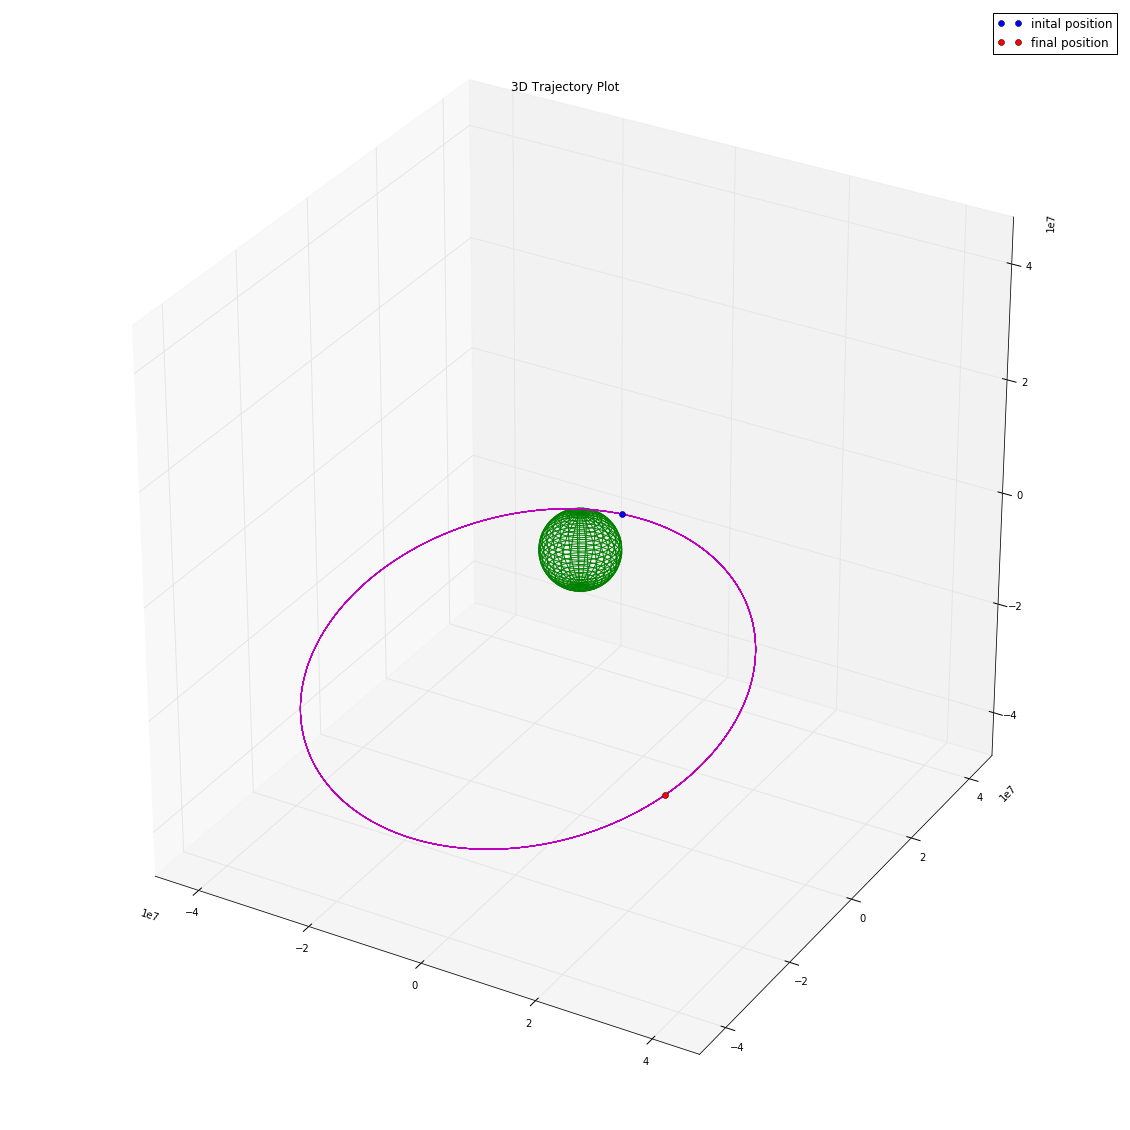

INITIAL CONDITIONS
x = 0.0
y = 6671000.0
vx = 7758.98631654
vy = 0.0
-6041025.78768 2896440.45216 6699504.44886
3387.50517866 6943.93487693


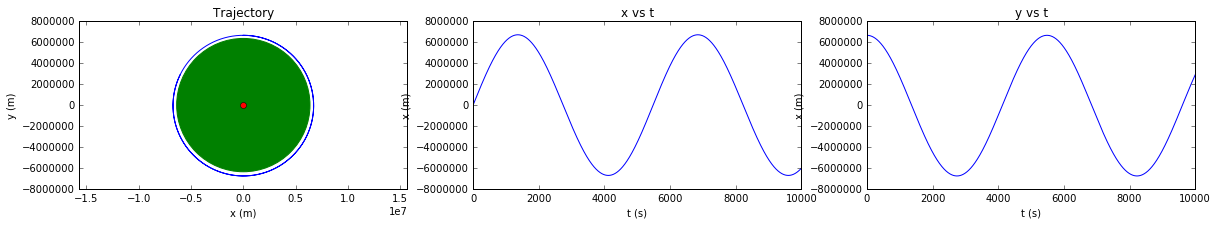

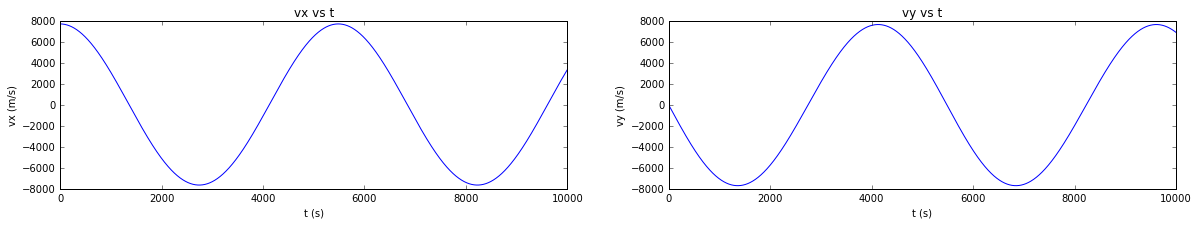

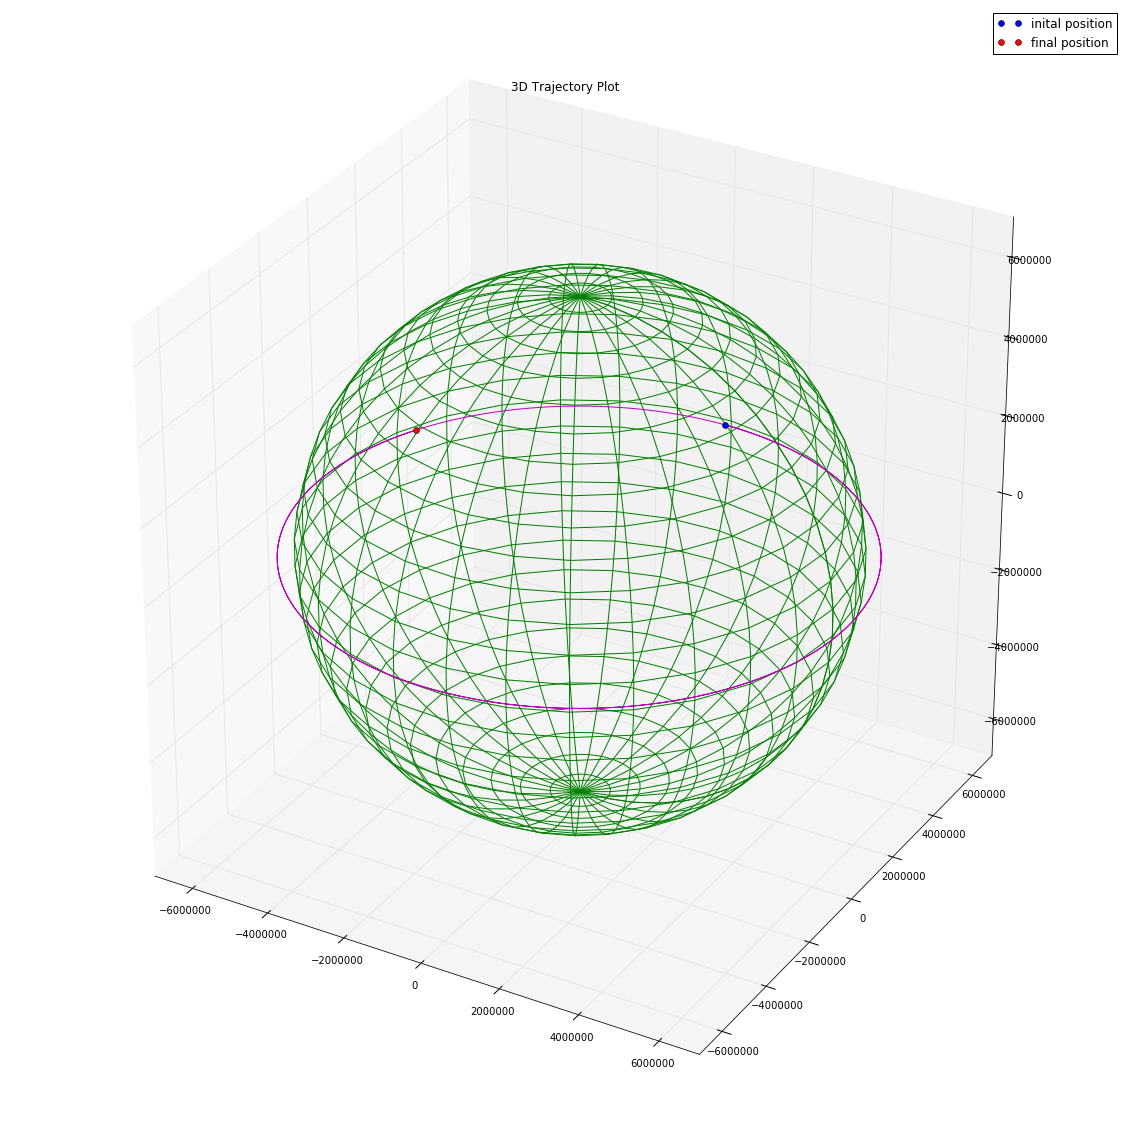

INITIAL CONDITIONS
x = 0.0
y = 6521000.0
vx = 6207.18905324
vy = 6207.18905324
5527669.78863 -3177346.60871 6375787.38385
-4.60743150226 2.64838664724


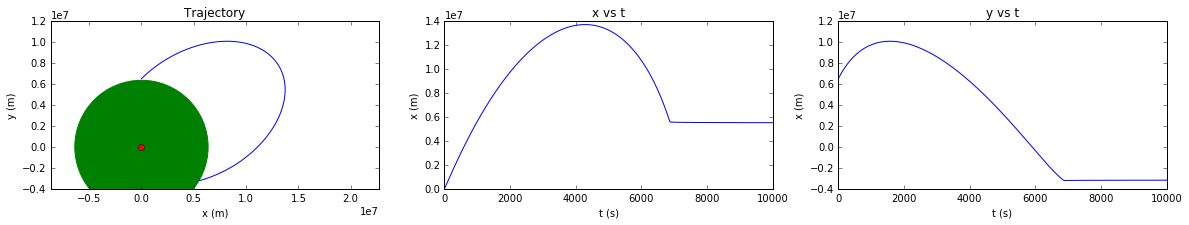

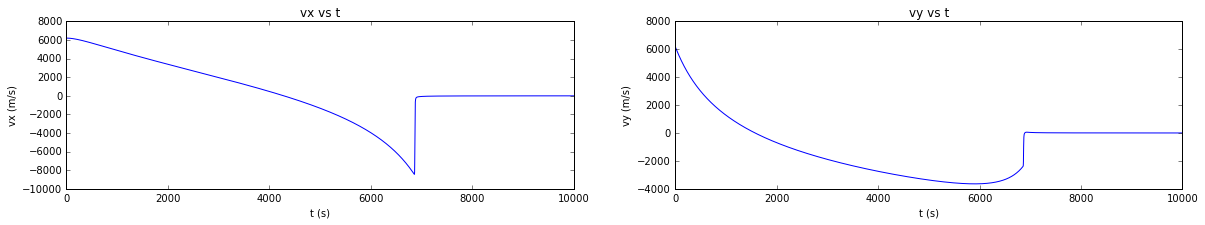

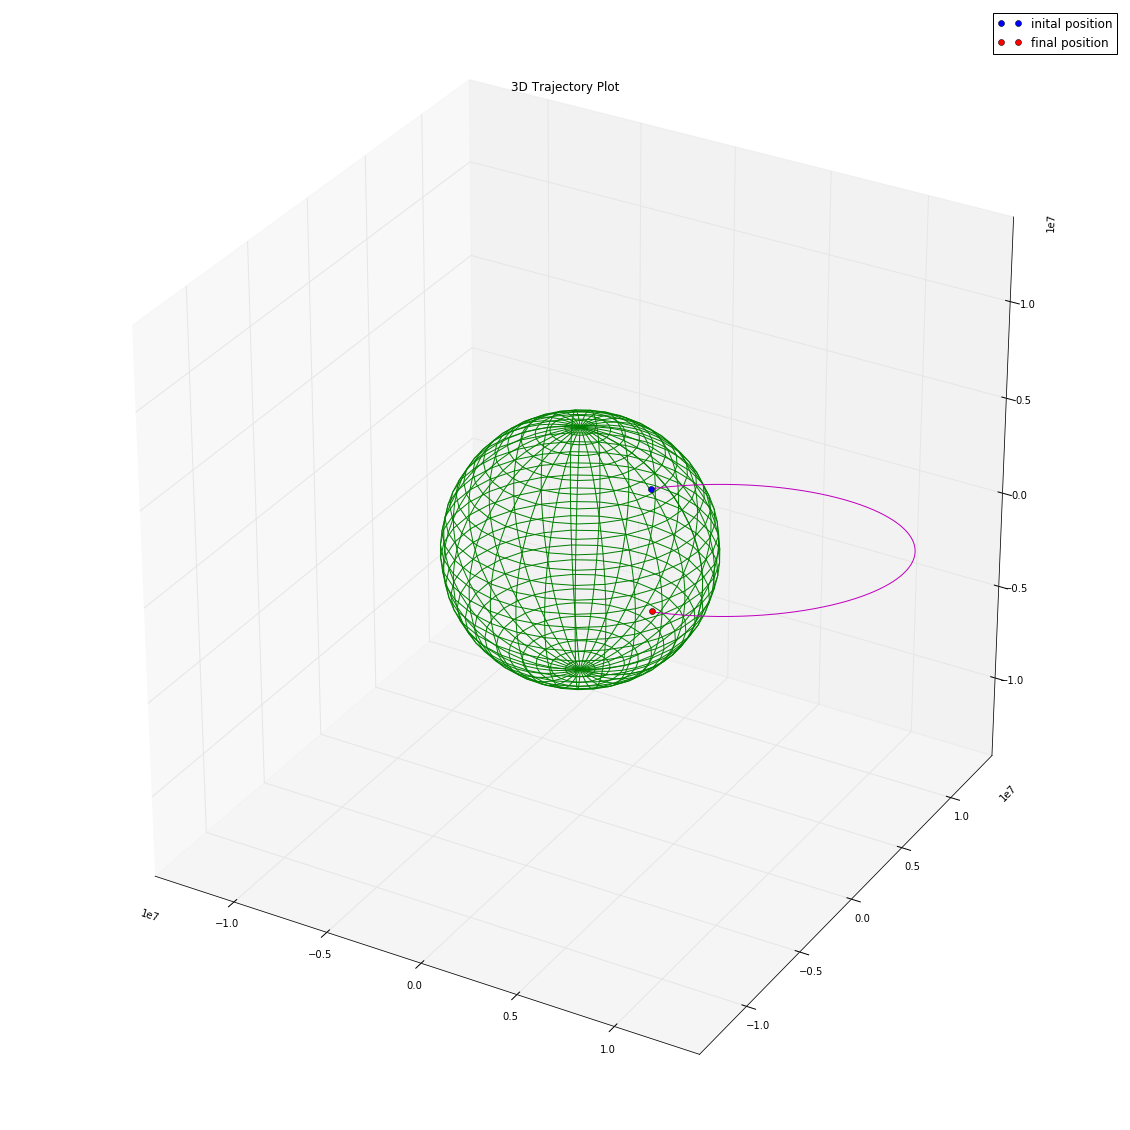

In [312]:
plot_test_F4()